# HW 2 - Using Naive Bayes
R. Mattson |  CSCI 6340 | 3-02-2021

The text files were chunked into sets of 500 words with NLTK `word_tokenize`. However they were then converted to a sparse representation of their counts using sklearn's `CountVectorizer`. Two methods were used to split the data into testing and training sets. First, a test set was manually created from 5 texts given in the assignment instructions. Secondly, the chunks text were randomly assigned into test and train sets by sklearns 'test_train_split'. Experiments were also performed using all of the text data, and then using data where instances of the largest class were reduced. The Dicken's class takes up an inordinate amount on the data set- I simply dropped 300 of the 895 Dickens samples.

Overall, creating the train/test sets randomly rather than by novel had the best impact on model performance. Dropping data showed marginal improvement in some models, but led to a significant uptick in classification errors for the reduced class.  The Bernoulli classifier had the greatest success "out of the box".

To sum up some of the accuracy stats:   
 

| Model       | basic       | random split | dropped data|
| ----------- | ----------- |  ----------- | ----------- |
| Multinomial | .91         |  .98         | .93
| Bernoulli   | .96         |  .97         | .95
| Gaussian    | .60         |  .96         | .62
| Complement  | .84         |  .98         | .86

The code and classification matrices are shown below. The sequence of tests are generated by `test(directory)` - run all cells to execute. With reading the text, calculating accuracy, and converting data to a dense array for the `GaussianNB` model, the code takes a minute or two to complete.

In [11]:
import pandas as pd
import numpy as np
# import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

import os
import zipfile
import urllib

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/ram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
def show_conf_mat(conf_mat, class_label_list, title=''):
    num_classes = len(class_label_list)
    ticks = np.arange(num_classes)+0.5
    
    seaborn.heatmap(conf_mat, cmap='RdPu', 
            xticklabels=class_label_list, yticklabels=class_label_list,
            annot=True, fmt='d', annot_kws={'size': 12, 'weight':'bold'})
    
    plt.title(title, fontsize=18); 
    plt.xlabel('Prediction', fontsize=16);
    plt.xlim(0,num_classes)
    plt.xticks(ticks, class_label_list, rotation=45)
    
    plt.ylabel('Truth', fontsize=16);
    plt.ylim(0,num_classes)
    plt.yticks(ticks, class_label_list,rotation='horizontal') 
#     plt.invert_yaxis();
    plt.gca().invert_yaxis()
    plt.axis('auto')
    plt.show()

In [14]:
def read_text_v2(directory="text/"):
    print("Reading text...")

    DF = pd.DataFrame(columns=['text','author','title'])
    
#     I adapted code from stackechange to learn os.walk
#     https://stackoverflow.com/questions/54471432/reading-multiple-files-from-a-same-folder-using-python
    for root, dirs, files in os.walk(directory):
        for file in files:
            filename, extension = os.path.splitext(file)
            if extension == '.txt':
                
                # get the author and title classes
                vec = filename.split('-')
                author =  vec[1] + ' ' + vec[0]
                title = vec[2] 
#                 print("Reading "+ author + "..." + "title" + title)
                
                # collect substrings containing 500 tokens
                fullpath = os.path.join(root, file )
                with open(fullpath, 'r') as f:
                    str_ = f.read()
                    chunks = simple_chunker_v3(str_)
#                     print(len(chunks), "sets of 500 tokens found")
                    df_ = pd.DataFrame(chunks, columns=['text'])
                    df_["author"] = author
                    df_["title"] = title
                    DF = DF.append(df_,ignore_index=True)
               
    
    print("Finished collecting text")
    return DF


# DF = read_text_v2("text/")


In [15]:
# This is code given by Dr. Maier. I changed some thing around while I was figuring it out, 
# then ended up using the original proccess with a different chunk_size 

def simple_chunker_v3(text, chunk_size=500):
    """splits text string into a list of strings, each 
    element string containing 'chunk_size' tokens.
    Pads the end of the string for easy reshaping using numpy.
    """
    toks = word_tokenize(text)
    to_pad = chunk_size - len(toks) % chunk_size
    toks.extend(['' for i in range(to_pad)])
    array = np.array(toks)
    array = array.reshape(-1, chunk_size)
#     array = array.reshape(1,-1)
#     return array
    return [' '.join(e) for e in array]

In [16]:
def trial(DF, model=MultinomialNB(), random_split=False, dense=False):
    
    """Classifies a set of text by author, displays accuracy and confusion matrix"""
    class_types = ['Jane Austen', 'Joseph Conrad', 'Lousia May Alcott', 'Charles Dickens', 'Charlotte Bronte']
    
     # Bulk of the preproccessing 
#     DF = read_text_v2(path_to_directory)

    # Convert the author's names to a format the model can use              
    le = LabelEncoder()
    DF['author_type'] = le.fit_transform(DF['author'])

    # vectorize our chunks to transform into a type usable by the model
    count_vect = CountVectorizer()
    count_vect.fit(DF['text'])
    
    if random_split:
        X = count_vect.transform(DF['text'])
        Y = DF['author_type']
        x_train, x_test, y_train, y_test =  train_test_split(X, Y, test_size=0.2, random_state=7)
        print("Test Size =", len(y_test))
    else:
        # Manual test/train split based on HW instructions
        TEST_SET = ['Little Women','Sense and Sensibility', 'Villette', 'Heart of Darkness', 'David Copperfield']
        title_filter = DF.title.isin(TEST_SET)
        TRAIN = DF[~title_filter]
        TEST = DF[title_filter]
        
        x_train = count_vect.transform(TRAIN['text'])
        x_test = count_vect.transform(TEST['text'])
        y_train = TRAIN['author_type']
        y_test = TEST['author_type']
        
    if dense:
        print('Converting data to dense array')
        x_train = x_train.toarray()
        x_test = x_test.toarray()

    model_name = type(model).__name__
    
    # Do the work!
    y_pred = model.fit(x_train, y_train).predict(x_test)
    
    acc = np.sum(y_pred == y_test) / len(y_test)
#     acc = np.mean(y_pred == y_test) # Maiers way
    print(model_name ,"accuracy =", "%.2f" % acc)
    
    # plotting...
    mat = confusion_matrix(y_test, y_pred)
    labels = list(le.inverse_transform([0,1,2,3,4]))    
    show_conf_mat(mat, labels, model_name)
    
    return y_pred


In [17]:
DF = pd.DataFrame

In [18]:
def test(path_to_directory="text/"):
    
    multi = MultinomialNB()
    bernie = BernoulliNB()
    complement = ComplementNB()
#     catty = CategoricalNB()
    gaussy = GaussianNB()
    
    # Bulk of the preproccessing 
    DF = read_text_v2(path_to_directory)
    
    print('\033[1m'+ "Basic Performance" + '\033[0m')
    y_pred_multi = trial(DF, multi)
    y_pred_bernie = trial(DF, bernie)
    y_pred_comp = trial(DF, complement)
    y_pred_gn = trial(DF, gaussy, dense=True)
    
    print('\033[1m'+ "Performance with Random Sampling" + '\033[0m')
    y_pred_multi = trial(DF, multi, random_split=True)
    y_pred_bernie = trial(DF, bernie, random_split=True)
    y_pred_comp = trial(DF, complement, random_split=True)
    y_pred_gn = trial(DF, gaussy,random_split=True, dense=True)
    
    # drop some Dickens
    DF.drop(DF.tail(300).index, 
        inplace = True) 
    
    print('\033[1m'+"Performance with dropped data"'\033[0m') 
    y_pred_multi = trial(DF, multi,)
    y_pred_bernie = trial(DF, bernie)
    y_pred_comp = trial(DF, complement)
    y_pred_gn = trial(DF, gaussy, dense=True)


Retrieving Data...
Reading text...
Finished collecting text
Basic Performance
MultinomialNB accuracy = 0.91


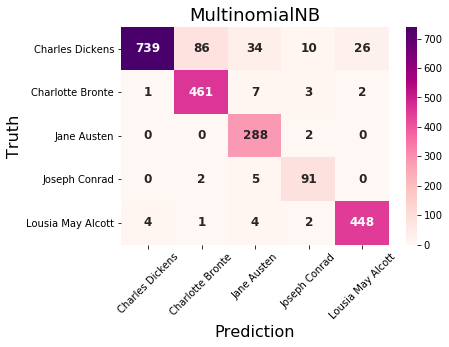

BernoulliNB accuracy = 0.96


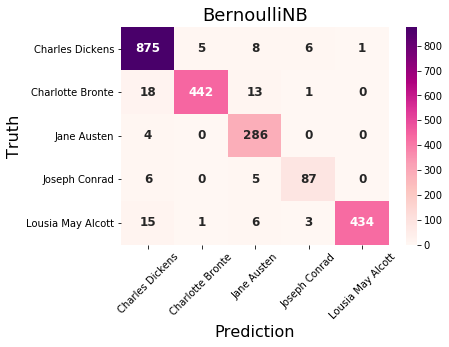

ComplementNB accuracy = 0.84


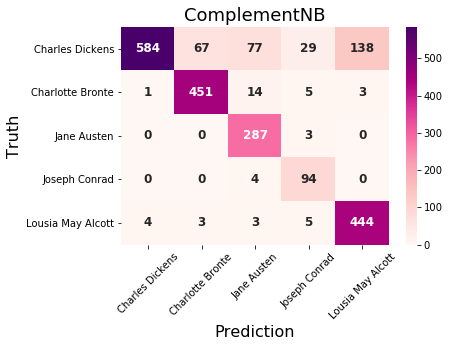

Converting data to dense array
GaussianNB accuracy = 0.60


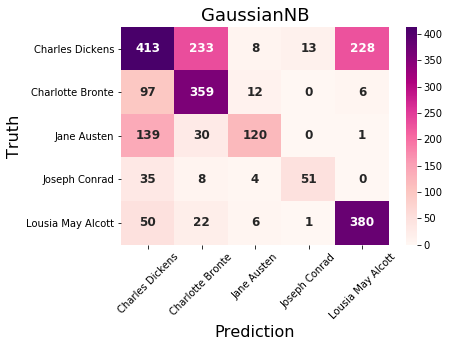

Performance with Random Sampling
Test Size = 1802
MultinomialNB accuracy = 0.98


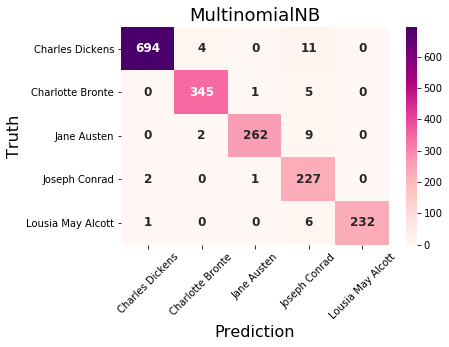

Test Size = 1802
BernoulliNB accuracy = 0.97


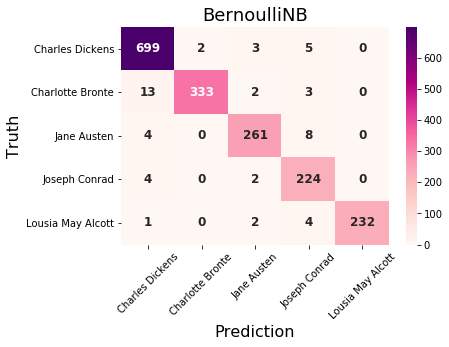

Test Size = 1802
ComplementNB accuracy = 0.98


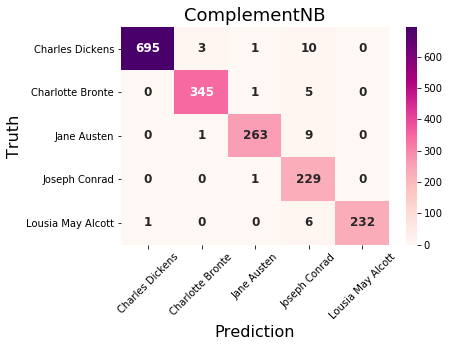

Test Size = 1802
Converting data to dense array
GaussianNB accuracy = 0.95


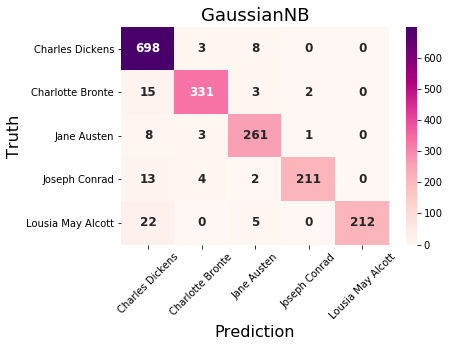

Performance with dropped data
MultinomialNB accuracy = 0.93


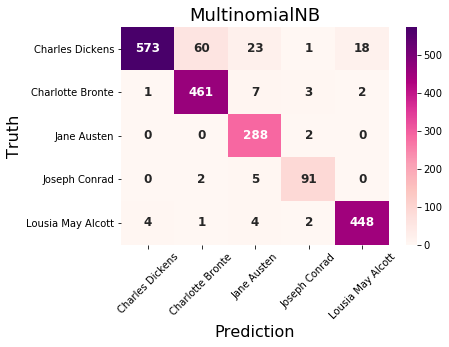

BernoulliNB accuracy = 0.96


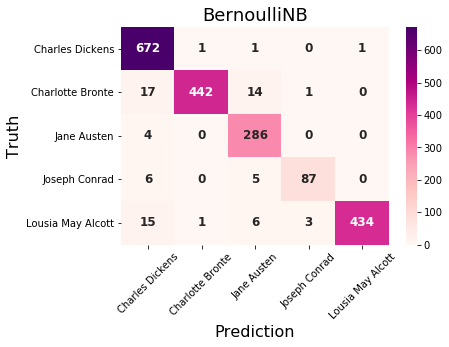

ComplementNB accuracy = 0.86


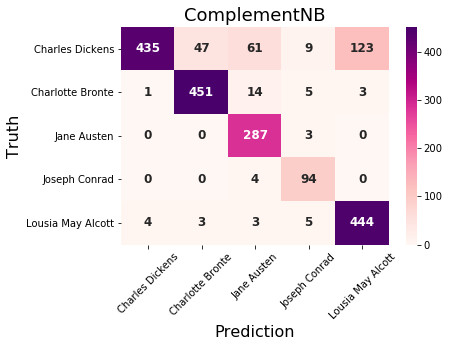

Converting data to dense array
GaussianNB accuracy = 0.62


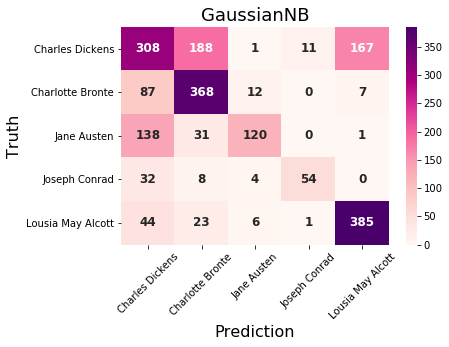

In [21]:
print("Retrieving Data...")
url = "https://docs.google.com/uc?export=download&id=1RoTCAcsP_qA2pFXwzxLDQjLUnu5mnhFv"
urllib.request.urlretrieve(url, "text.zip")
with zipfile.ZipFile('text.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

test("data/text/")

![buffy-the-vampire-slayer](https://media1.tenor.com/images/2988114c5b0435f77ab31f11833562e8/tenor.gif?itemid=5710827)